영구 포트폴리오는 주식, 국채, 금, 현금을 각각 25%씩 투자하는 전략입니다. 이 비율을 변형하여 전략의 안정성을 크게 떨어뜨리지 않으면서 수익성을 개선하는 전략이 있습니다. 미국 기준으로 주식 20%, 소형 가치주 20%, 장기 국채 20%, 금 20%, 현금(단기 국채) 20% 비율로 투자하는 Goldenbutterfly(황금나비) 전략입니다.

In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import backtrader as bt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pyfolio as pf
import quantstats
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


금 ETF인 GLD가 2004-11-18 데이터부터 있으므로, 그 시점부터 시작합니다.

In [2]:
# VTSMX (미국 주식), VBR (미국 소형 가치주), VUSTX (미국 국채), GLD (금), SHY (단기 국채)

start = '2004-11-18'
end = '2021-02-12'

vtsmx = web.DataReader('VTSMX', 'yahoo', start, end)['Adj Close'].to_frame("Close")
vbr = web.DataReader('VBR', 'yahoo', start, end)['Adj Close'].to_frame("Close")
vustx = web.DataReader('VUSTX', 'yahoo', start, end)['Adj Close'].to_frame("Close")
gld = web.DataReader('GLD', 'yahoo', start, end)['Adj Close'].to_frame("Close")
shy = web.DataReader('SHY', 'yahoo', start, end)['Adj Close'].to_frame("Close")

Backtrader 패키지의 input 형태를 맞춥니다.

In [3]:
for column in ['Open', 'High', "Low"]:
    vtsmx[column] = vtsmx["Close"]
    vbr[column] = vbr['Close']
    vustx[column] = vustx["Close"]
    gld[column] = gld["Close"]
    shy[column] = shy["Close"]

주식, 소형 가치주, 장기 국채, 금, 현금(단기 국채) 각각을 20%씩 보유하면서 20 거래일마다 리밸런싱합니다.

In [4]:
class AssetAllocation_GoldenButterfly(bt.Strategy):
    params = (
        ('TotalStock',0.2),
        ('SmallCapValue', 0.2),
        ('Treasury', 0.2),
        ('Gold', 0.2),
        ('Cash', 0.2)
    )
    def __init__(self):
        self.VTSMX = self.datas[0]
        self.VBR = self.datas[1]
        self.VUSTX = self.datas[2]
        self.GLD = self.datas[3]
        self.SHY = self.datas[4]
        self.counter = 0
        
    def next(self):
        if  self.counter % 20 == 0:
            self.order_target_percent(self.VTSMX, target=self.params.TotalStock)
            self.order_target_percent(self.VBR, target=self.params.SmallCapValue)
            self.order_target_percent(self.VUSTX, target=self.params.Treasury)
            self.order_target_percent(self.GLD, target=self.params.Gold)
            self.order_target_percent(self.SHY, target=self.params.Cash)
        self.counter += 1

In [5]:
cerebro = bt.Cerebro()

cerebro.broker.setcash(1000000)

VTSMX = bt.feeds.PandasData(dataname = vtsmx)
VBR = bt.feeds.PandasData(dataname = vbr)
VUSTX = bt.feeds.PandasData(dataname = vustx)
GLD = bt.feeds.PandasData(dataname = gld)
SHY = bt.feeds.PandasData(dataname = shy)

cerebro.adddata(VTSMX)
cerebro.adddata(VBR)
cerebro.adddata(VUSTX)
cerebro.adddata(GLD)
cerebro.adddata(SHY)

cerebro.addstrategy(AssetAllocation_GoldenButterfly)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name = 'PyFolio')

results = cerebro.run()
strat = results[0]

portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)

quantstats.reports.html(returns, output = 'Report_AssetAllocation_GoldenButterfly.html', title='AssetAllocation_GoldenButterfly')

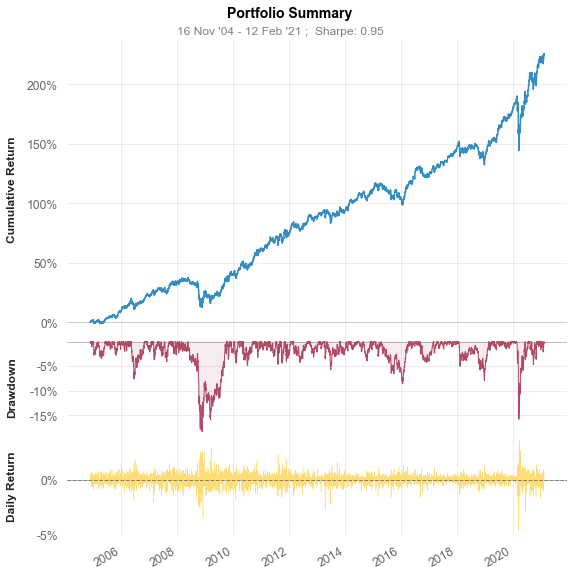

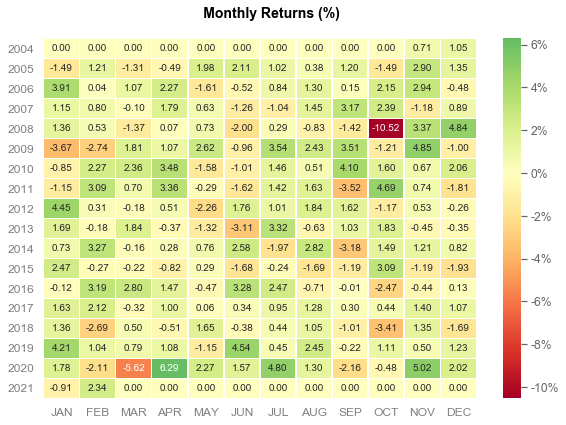

In [6]:
quantstats.reports.plots(returns, mode='basic')

In [7]:
quantstats.reports.metrics(returns, mode='full')

                           Strategy
-------------------------  ----------
Start Period               2004-11-17
End Period                 2021-02-12
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          225.01%
CAGR%                      7.52%
Sharpe                     0.95
Sortino                    1.35
Max Drawdown               -18.36%
Longest DD Days            505
Volatility (ann.)          7.94%
Calmar                     0.41
Skew                       -0.5
Kurtosis                   6.98

Expected Daily %           0.03%
Expected Monthly %         0.6%
Expected Yearly %          6.77%
Kelly Criterion            8.59%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.79%
Expected Shortfall (cVaR)  -0.79%

Payoff Ratio               0.95
Profit Factor              1.18
Common Sense Ratio         1.14
CPC Index                  0.62
Tail Ratio                 0.96
Outlier Win Ratio          3.66
Outlier Loss Ratio         3.56